## **Llama 3 for cause prediction**

In [2]:
# !pip install -r requirements.txt

In [69]:
from accelerate import Accelerator

In [4]:
import os
import torch
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    AutoConfig,
    BitsAndBytesConfig,
)
import time
import json
import matplotlib.pyplot as plt
import seaborn as sns
import wandb

In [5]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

#### **Define Prompt Template**

**Prompt template:**

\<s>[INST] \<\<SYS>>

{{system message}}

\<\</SYS>>

{{message/input}} [/INST] {{answer}} \</s>

<hr>



#### Sample training prompt with emotion labels
```
<s>[INST]

"conversation": [
            {
                "utterance_ID": 1,
                "text": "Alright , so I am back in high school , I am standing in the middle of the cafeteria , and I realize I am totally naked .",
                "speaker": "Chandler",
                "emotion": "neutral",
                "video_name": "dia1utt1.mp4"
            },
            {
                "utterance_ID": 2,
                "text": "Oh , yeah . Had that dream .",
                "speaker": "All",
                "emotion": "neutral",
                "video_name": "dia1utt2.mp4"
            },
            {
                "utterance_ID": 3,
                "text": "Then I look down , and I realize there is a phone ... there .",
                "speaker": "Chandler",
                "emotion": "surprise",
                "video_name": "dia1utt3.mp4"
            },
            {
                "utterance_ID": 4,
                "text": "Instead of ... ?",
                "speaker": "Joey",
                "emotion": "surprise",
                "video_name": "dia1utt4.mp4"
            },
            {
                "utterance_ID": 5,
                "text": "That is right .",
                "speaker": "Chandler",
                "emotion": "anger",
                "video_name": "dia1utt5.mp4"
            },
            {
                "utterance_ID": 6,
                "text": "Never had that dream .",
                "speaker": "Joey",
                "emotion": "neutral",
                "video_name": "dia1utt6.mp4"
            },
            {
                "utterance_ID": 7,
                "text": "No .",
                "speaker": "Phoebe",
                "emotion": "neutral",
                "video_name": "dia1utt7.mp4"
            },
            {
                "utterance_ID": 8,
                "text": "All of a sudden , the phone starts to ring .",
                "speaker": "Chandler",
                "emotion": "neutral",
                "video_name": "dia1utt8.mp4"
            }
        ]
Identify the cause utterances of the emotion in utterance 5. Output in one line the ids of the cause utterances as a list in the given format:
utterance_id :: [cause utterance ids]
Don't give any explanation.
[/INST]
utterance_id :: [1,3,4]
</s>
```

#### **Preprocess the Input**

In [6]:
with_labels = True

In [7]:
def get_prompt_without_output(sample_data_point, speaker=False, video=False, audio=False):
	if speaker and video and audio:
		instruction = """Identify the cause utterances of the emotion in utterance {}. The video_captions for each utterance describe the video corresponding to the text.\nOutput in one line the ids of the cause utterances as a list in the given format:\nutterance_ids :: [cause utterance ids]\nDon't give any explanation.""".format(sample_data_point["utterance_id"])
	elif speaker and video:
		instruction = """Identify the cause utterances of the emotion in utterance {}. The video_captions for each utterance describe the video corresponding to the text.\nOutput in one line the ids of the cause utterances as a list in the given format:\nutterance_ids :: [cause utterance ids]\nDon't give any explanation.""".format(sample_data_point["utterance_id"])
	else:
		instruction = """Identify the cause utterances of the emotion in utterance {}. Output in one line the ids of the cause utterances as a list in the given format:\nutterance_ids :: [cause utterance ids]\nDon't give any explanation.""".format(sample_data_point["utterance_id"])

	return f"""<s>[INST]\n{sample_data_point['conversation']}{instruction}\n[/INST]\n"""

In [8]:
def get_prompt_with_output(sample_data_point, speaker=False, video=False, audio=False):
	if speaker and video and audio:
		instruction = """Identify the cause utterances of the emotion in utterance {}. The video_captions for each utterance describe the video corresponding to the text.\nOutput in one line the ids of the cause utterances as a list in the given format:\nutterance_ids :: [cause utterance ids]\nDon't give any explanation.""".format(sample_data_point["utterance_id"])
	elif speaker and video:
		instruction = """Identify the cause utterances of the emotion in utterance {}. The video_captions for each utterance describe the video corresponding to the text.\nOutput in one line the ids of the cause utterances as a list in the given format:\nutterance_ids :: [cause utterance ids]\nDon't give any explanation.""".format(sample_data_point["utterance_id"])
	else:
		instruction = """Identify the cause utterances of the emotion in utterance {}. Output in one line the ids of the cause utterances as a list in the given format:\nutterance_ids :: [cause utterance ids]\nDon't give any explanation.""".format(sample_data_point["utterance_id"])

	return f"""<s>[INST]\n{sample_data_point['conversation']}{instruction}\n[/INST]\n""", f"""utterance_ids :: {sample_data_point['causes_label']}\n</s>"""


In [9]:
def get_formatted_conversation(data_sample, speaker=False, video=False, audio=False):
    conversation_str = '"conversation": [\n'
    for utt in data_sample["conversation"]:
        conversation_str += "{{\n\"utterance_ID\": {}\n\"text\": {}\n\"speaker\": {}\n\"emotion\": {}\n}}\n".format(utt["utterance_ID"], utt["text"], utt["speaker"], utt["emotion"])
    return conversation_str

In [10]:
def get_causes_list_str(cause_list):
    str_out = "["
    i = 0
    while i < len(cause_list):
        if i == len(cause_list)-1:
            str_out += str(cause_list[i])
        else:
            str_out += str(cause_list[i]) + ","
        i += 1
    str_out += "]"
    return str_out

In [11]:
def form_input(data_sample, utt_id, speaker=False, video=False, audio=False):
    conversation_str = get_formatted_conversation(data_sample, speaker, video, audio)
    emotions_str = data_sample["conversation"][utt_id]["emotion"]
    if with_labels:
        causes_list_str = get_causes_list_str(data_sample["conversation"][utt_id]["cause_list"])

    sample_data_point = {} # has utterance_id, conversation, emotion_label, conv id

    sample_data_point["utterance_id"] = utt_id+1
    sample_data_point["conversation"] = conversation_str
    sample_data_point["emotion_label"] = emotions_str
    if with_labels:
        sample_data_point["causes_label"] = causes_list_str
    sample_data_point["causes_list"] = data_sample["conversation"][utt_id]["cause_list"]
    sample_data_point["conversation_id"] = data_sample["conversation_ID"]
    return sample_data_point


In [12]:
def generate_inst_for_each_utt_of_conv(data_point, speaker=False, video=False, audio=False):
    num_utt = len(data_point["conversation"])
    list_output_objects = []
    for i in range(num_utt):
        sample_data_point = form_input(data_point, i, speaker, video, audio)
        if with_labels:
            inst, out = get_prompt_with_output(sample_data_point, speaker, video, audio)
        else:
            inst = get_prompt_without_output(sample_data_point, speaker, video, audio)
        if with_labels:
            obj = {
                "instruction": inst,
                "out": out,
                "text": inst + out,
                "emotion_label": sample_data_point["emotion_label"],
                "utterance_id": sample_data_point["utterance_id"],
                "conversation_id": sample_data_point["conversation_id"],
                "causes_label":sample_data_point["causes_label"],
                "causes_list":sample_data_point["causes_list"]
            }
        else:
            obj = {
                "instruction": inst,
                "emotion_label": sample_data_point["emotion_label"],
                "utterance_id": sample_data_point["utterance_id"],
                "conversation_id": sample_data_point["conversation_id"],
            }
        list_output_objects.append(obj)
    return list_output_objects

In [13]:
def process_dataset(data, speaker=False, video=False, audio=False):
    flattened_list = [element for sublist in map(lambda x: generate_inst_for_each_utt_of_conv(x, speaker, video, audio), data) for element in sublist]
    ds = {}
    # IMP: only include those utterances in dataset where emotion is not "neutral", we will only find cause list for those
    ds["instruction"] = [sample["instruction"] for sample in flattened_list if sample["emotion_label"] != "neutral"]
    ds["emotion_label"] = [sample["emotion_label"] for sample in flattened_list if sample["emotion_label"] != "neutral"]
    ds["utterance_id"] = [sample["utterance_id"] for sample in flattened_list if sample["emotion_label"] != "neutral"]
    ds["conversation_id"] = [sample["conversation_id"] for sample in flattened_list if sample["emotion_label"] != "neutral"]
    if with_labels:
        ds["causes_label"] = [sample["causes_label"] for sample in flattened_list if sample["emotion_label"] != "neutral"]
        ds["causes_list"] = [sample["causes_list"] for sample in flattened_list if sample["emotion_label"] != "neutral"]
        ds["out"] = [sample["out"] for sample in flattened_list if sample["emotion_label"] != "neutral"]
        ds["text"] = [sample["text"] for sample in flattened_list if sample["emotion_label"] != "neutral"]
    return ds

In [14]:
from sklearn.model_selection import train_test_split

def create_json(data, save_folder, speaker=False, video=False, audio=False):

    if not os.path.exists(save_folder):
        os.makedirs(save_folder)
    else:
        print("Input already present at {}\n".format(save_folder))
        conv_file = os.path.join(save_folder,"conversations.json")
        return conv_file

    # create a map for storing cause_list for each utt of each conv
    # map of map
    cause_map = {}
    for conv in data:
        conv_id = conv["conversation_ID"]
        cause_map[conv_id] = {}
        for pair in conv["emotion-cause_pairs"]:
            emo_id = int(pair[0].split('_')[0])
            cau_id = int(pair[1])
            if emo_id in cause_map[conv_id].keys():
                cause_map[conv_id][emo_id].append(cau_id)
            else:
                cause_map[conv_id][emo_id] = [cau_id]
    # Now go through utt and add their "cause_list", could be [] for neutral
    for conv in data:
        conv_id = conv["conversation_ID"]
        if conv_id not in cause_map.keys():
            for utt in conv["conversation"]:
                utt["cause_list"] = []
        else:
            for utt in conv["conversation"]:
                utt_id = utt["utterance_ID"]
                if utt_id not in cause_map[conv_id].keys():
                    utt["cause_list"] = []
                else:
                    utt["cause_list"] = cause_map[conv_id][utt_id]


    print("Number of conversations in dataset: {}".format(len(data)))

    conv_file = os.path.join(save_folder,"conversations.json")
    with open(conv_file, 'w') as f:
        json.dump(data, f)
    return conv_file

def generate_input(args):
    text_folder = os.path.join("..\\data\\text")
    save_dir = os.path.join("..\\Llama3\\input2")
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    file_path = os.path.join(text_folder, "Subtask_2_train.json")
    file = open(file_path)
    data = json.load(file)

    data_trainval, data_test = train_test_split(data, test_size=0.1, random_state=args.seed)
    data_train, data_val = train_test_split(data_trainval, test_size=0.1, random_state=args.seed)

    save_folder_test = os.path.join(save_dir, 'test')
    save_folder_train = os.path.join(save_dir, 'train')
    save_folder_val = os.path.join(save_dir, 'val')

    test_file = create_json(data_test, save_folder_test, args.speaker, args.video, args.audio)
    train_file = create_json(data_train, save_folder_train, args.speaker, args.video, args.audio)
    val_file = create_json(data_val, save_folder_val, args.speaker, args.video, args.audio)
    return test_file, train_file, val_file


In [15]:
# Params
class Config:
    def __init__(self) -> None:
        self.seed = 42
        self.speaker = True
        self.video = False
        self.audio = False

In [16]:
train_data = []
test_data = []
val_data = []

In [17]:
config = Config()
from datasets import Dataset

if with_labels:
    test_file, train_file, val_file = generate_input(config)

    with open(train_file, 'r') as f:
        train_data = json.load(f)
    with open(val_file, 'r') as f:
        val_data = json.load(f)
    with open(test_file, 'r') as f:
        test_data = json.load(f)

    print(len(train_data))
    print(len(test_data))
    print(len(val_data))
    train_data = train_data
    val_data = val_data
    test_data = test_data

    # Form datasets from data
    train_dataset = process_dataset(train_data, speaker=config.speaker, video=config.video)
    val_dataset = process_dataset(val_data, speaker=config.speaker, video=config.video)
    test_dataset = process_dataset(test_data, speaker=config.speaker, video=config.video)

    train_dataset = Dataset.from_dict(train_dataset)
    val_dataset = Dataset.from_dict(val_dataset)
    test_dataset = Dataset.from_dict(test_dataset)

    print("Train len {}".format(len(train_dataset)))
    print("Test len {}".format(len(test_dataset)))
    print("Val len {}".format(len(val_dataset)))
    dataset = train_dataset
else:
    with open("./emotion_labelled_data.json", 'r') as f:
        data = json.load(f)
        dataset = process_dataset(data, speaker=config.speaker, video=config.video)
        dataset = Dataset.from_dict(dataset)
        print("len {}".format(len(dataset["instruction"])))

Input already present at ..\Llama2\input2\test

Input already present at ..\Llama2\input2\train

Input already present at ..\Llama2\input2\val

1112
138
124
Train len 6209
Test len 778
Val len 703


### 3. Fine-tune Llama 2 using QLoRA
[QLoRA: Efficient Finetuning of Quantized LLMs](https://arxiv.org/abs/2305.14314)

In [18]:
print(dataset["text"][0])

<s>[INST]
"conversation": [
{
"utterance_ID": 1
"text": Really ? You would ... you would do that for me ? !
"speaker": Joey
"emotion": surprise
}
{
"utterance_ID": 2
"text": Yeah !
"speaker": Ross
"emotion": joy
}
{
"utterance_ID": 3
"text": Thanks !
"speaker": Joey
"emotion": joy
}
{
"utterance_ID": 4
"text": All right , we will start off slow . The only thing you have to do tonight is come up with the name of your main character .
"speaker": Ross
"emotion": neutral
}
{
"utterance_ID": 5
"text": Done !
"speaker": Joey
"emotion": joy
}
{
"utterance_ID": 6
"text": And it can not be Joey .
"speaker": Ross
"emotion": neutral
}
{
"utterance_ID": 7
"text": It is not .
"speaker": Joey
"emotion": neutral
}
{
"utterance_ID": 8
"text": Or Joseph .
"speaker": Ross
"emotion": neutral
}
{
"utterance_ID": 9
"text": Oh .
"speaker": Joey
"emotion": neutral
}
Identify the cause utterances of the emotion in utterance 1. Output in one line the ids of the cause utterances as a list in the given format:
u

In [19]:
# Can't Load the model on a 4GB or even 16GB GPU, so use accelerate for automatically creating device map
import accelerate

In [20]:
model_id = "models--Undi95--Meta-Llama-3-8B-Instruct-hf"

In [21]:
# Paste write token
# !huggingface-cli login

In [22]:
model_config = AutoConfig.from_pretrained(model_id)

with accelerate.init_empty_weights():
    fake_model = AutoModelForCausalLM.from_config(model_config)

device_map=accelerate.infer_auto_device_map(fake_model, max_memory={0: "24GiB", "cpu": "20GiB"}) #
print(json.dumps(device_map, indent=4))

{
    "model.embed_tokens": 0,
    "model.layers.0": 0,
    "model.layers.1": 0,
    "model.layers.2": 0,
    "model.layers.3": 0,
    "model.layers.4": 0,
    "model.layers.5": 0,
    "model.layers.6": 0,
    "model.layers.7": 0,
    "model.layers.8": 0,
    "model.layers.9": 0,
    "model.layers.10": 0,
    "model.layers.11": 0,
    "model.layers.12": 0,
    "model.layers.13": 0,
    "model.layers.14": 0,
    "model.layers.15": 0,
    "model.layers.16": 0,
    "model.layers.17": 0,
    "model.layers.18": 0,
    "model.layers.19": 0,
    "model.layers.20": 0,
    "model.layers.21": 0,
    "model.layers.22": 0,
    "model.layers.23": 0,
    "model.layers.24.self_attn": 0,
    "model.layers.24.mlp.gate_proj": 0,
    "model.layers.24.mlp.up_proj": "cpu",
    "model.layers.24.mlp.down_proj": "cpu",
    "model.layers.24.mlp.act_fn": "cpu",
    "model.layers.24.input_layernorm": "cpu",
    "model.layers.24.post_attention_layernorm": "cpu",
    "model.layers.25": "cpu",
    "model.layers.26"

In [23]:
# Use 4-bit quantized version of model, wgts and activations -> 4 bits
compute_dtype = getattr(torch, "float16")
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4", # 4-bit quantized noraml float
    bnb_compute_dtype=compute_dtype,
    llm_int8_enable_fp32_cpu_offload=True,
)

In [24]:
model = AutoModelForCausalLM.from_pretrained(model_id,
                                             quantization_config=bnb_config,
                                             device_map={"": Accelerator().local_process_index},
                                             offload_folder="/tmp/.offload",
                                             low_cpu_mem_usage=True,
                                             torch_dtype=torch.float16,
                                             )
tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_size = "right"

Loading checkpoint shards: 100%|██████████████████████████████████████████████████████████| 4/4 [00:11<00:00,  2.90s/it]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


#### **Zero Shot Inference**

In [25]:
index = 0
prompt = test_dataset["instruction"][index]
print("promt:      ",prompt)

inputs = tokenizer(prompt, return_tensors='pt')
output = tokenizer.decode(
    model.generate(
        input_ids=inputs["input_ids"],
        max_new_tokens=25,
    )[0],
    skip_special_tokens=True
)

dash_line = '-'.join('' for x in range(100))
print(dash_line)
print(f'INPUT PROMPT:\n{prompt}')
print(dash_line)
print(f'BASELINE OUTPUT:\n{train_dataset["out"][index]}')
print(dash_line)
print(f'MODEL OUTPUT (ZERO SHOT):\n{output}')
print(dash_line)

D:\MiniConda\envs\pythonProject6\lib\site-packages\transformers\generation\utils.py:1518: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


promt:       <s>[INST]
"conversation": [
{
"utterance_ID": 1
"text": Hey !
"speaker": Joey
"emotion": joy
}
{
"utterance_ID": 2
"text": So , what are you guys in the market for ? We have got uh , scarves , tulip post cards ...
"speaker": The Vendor
"emotion": neutral
}
{
"utterance_ID": 3
"text": Check this out ? Huh ? Yeah . That is the stuff . What do you think ?
"speaker": Joey
"emotion": joy
}
{
"utterance_ID": 4
"text": Well , I do not have to buy that , " I am with stupid " T ... shirt anymore .
"speaker": Chandler
"emotion": neutral
}
{
"utterance_ID": 5
"text": Well , I like it . Here you go .
"speaker": Joey
"emotion": neutral
}
{
"utterance_ID": 6
"text": All right , look , you are not really gonna buy that are you ? Do not you think you have embarrassed me enough for one day ?
"speaker": Chandler
"emotion": anger
}
{
"utterance_ID": 7
"text": Oh , I embarrass you ?
"speaker": Joey
"emotion": surprise
}
{
"utterance_ID": 8
"text": How can I answer that when I am pretending I 

D:\MiniConda\envs\pythonProject6\lib\site-packages\transformers\generation\utils.py:1636: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(
D:\MiniConda\envs\pythonProject6\lib\site-packages\bitsandbytes\nn\modules.py:451: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(


---------------------------------------------------------------------------------------------------
INPUT PROMPT:
<s>[INST]
"conversation": [
{
"utterance_ID": 1
"text": Hey !
"speaker": Joey
"emotion": joy
}
{
"utterance_ID": 2
"text": So , what are you guys in the market for ? We have got uh , scarves , tulip post cards ...
"speaker": The Vendor
"emotion": neutral
}
{
"utterance_ID": 3
"text": Check this out ? Huh ? Yeah . That is the stuff . What do you think ?
"speaker": Joey
"emotion": joy
}
{
"utterance_ID": 4
"text": Well , I do not have to buy that , " I am with stupid " T ... shirt anymore .
"speaker": Chandler
"emotion": neutral
}
{
"utterance_ID": 5
"text": Well , I like it . Here you go .
"speaker": Joey
"emotion": neutral
}
{
"utterance_ID": 6
"text": All right , look , you are not really gonna buy that are you ? Do not you think you have embarrassed me enough for one day ?
"speaker": Chandler
"emotion": anger
}
{
"utterance_ID": 7
"text": Oh , I embarrass you ?
"speaker":

#### **Analyzing the tokens**

The maximum context length for Llama is 4096.

In [26]:
#Tokenize each row in the Instruction and Out Columns in the  Dataset and Count the Total Number of Tokens
instruction_tokens_count = [len(tokenizer.tokenize(test_dataset["instruction"][i])) for i in range(len(train_dataset["instruction"][:50]))]
print("Instruction Tokens Count", instruction_tokens_count[:10])
print("Length of Instruction Tokens Count", len(instruction_tokens_count))

Instruction Tokens Count [622, 622, 622, 622, 622, 622, 622, 622, 414, 414]
Length of Instruction Tokens Count 50


In [27]:
out_tokens_count = [len(tokenizer.tokenize(test_dataset["out"][i])) for i in range(len(train_dataset["out"][:50]))]
print("out Tokens Count", out_tokens_count[:10])
print("Length of out Tokens Count", len(out_tokens_count))

out Tokens Count [10, 10, 10, 12, 8, 10, 12, 10, 8, 10]
Length of out Tokens Count 50


In [28]:
combine_tokens_count = [i + o for i, o in zip(instruction_tokens_count, out_tokens_count)]
print("out Tokens Count", combine_tokens_count[:10])
print("Length of out Tokens Count", len(combine_tokens_count))

out Tokens Count [632, 632, 632, 634, 630, 632, 634, 632, 422, 424]
Length of out Tokens Count 50


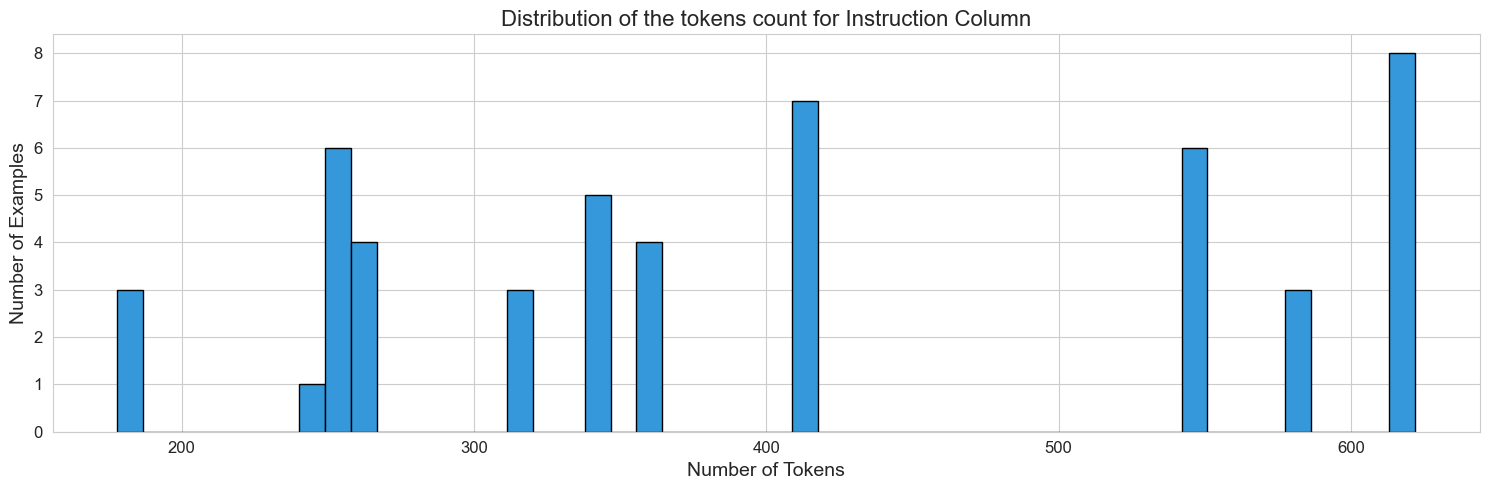

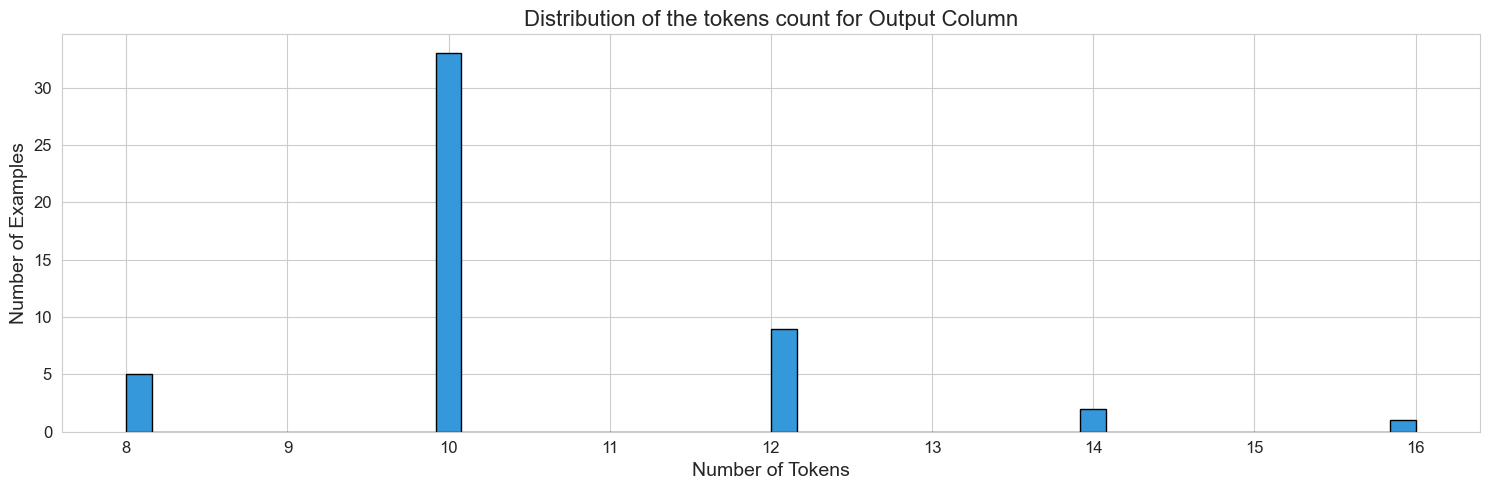

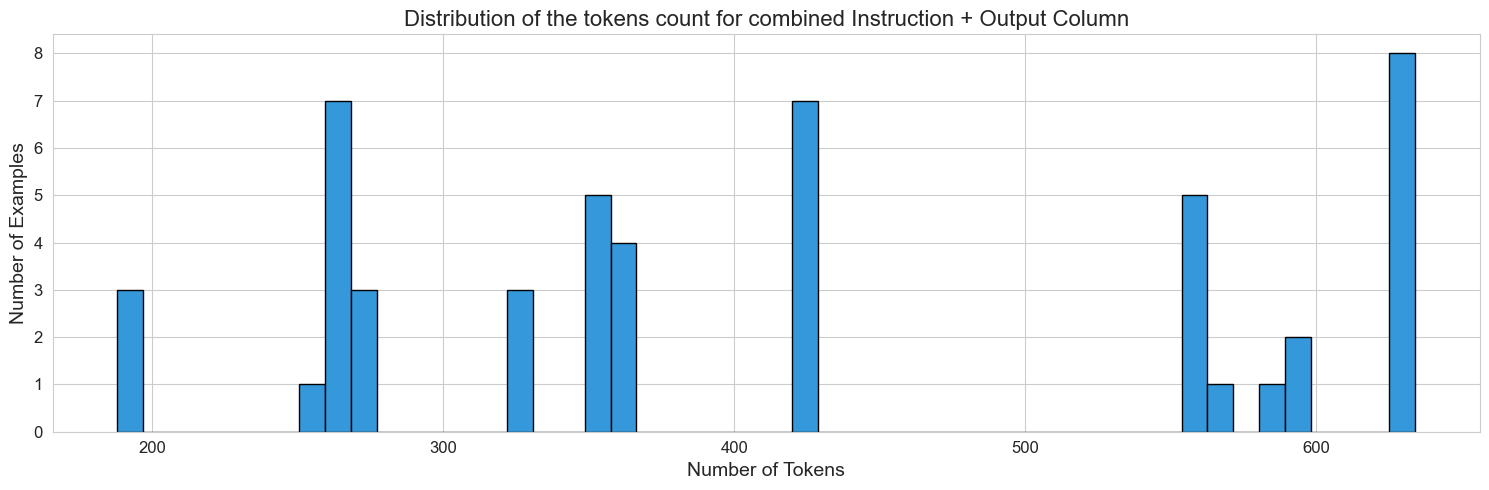

In [29]:
# Create a histogram using the matplotlib to see the distribution of our token counts
def plot_distribution(tokens_count, title):
  sns.set_style("whitegrid")
  plt.figure(figsize=(15, 5))
  plt.hist(tokens_count, bins=50, color='#3498db', edgecolor='black')
  plt.title(title, fontsize=16)
  plt.xlabel("Number of Tokens", fontsize=14)
  plt.ylabel("Number of Examples", fontsize=14)
  plt.xticks(fontsize=12)
  plt.yticks(fontsize=12)
  plt.tight_layout()
  plt.show()

# Insruction Tokens Count
plot_distribution(instruction_tokens_count, "Distribution of the tokens count for Instruction Column")
# Output Tokens Count
plot_distribution(out_tokens_count, "Distribution of the tokens count for Output Column")
# Combined Tokens Count
plot_distribution(combine_tokens_count, "Distribution of the tokens count for combined Instruction + Output Column")
# The mean is around 600 tokens for combined instruction and output

In [30]:
model.config.use_cache = False
model.config.pretraining_tp = 1

In [31]:
# With quantization memory footprint is reduced to nearly 11 Gb from 25 GB for llama 7b
print(f"Memory footprint in bytes: {model.get_memory_footprint()}")

Memory footprint in bytes: 5725765632


In [32]:
print(json.dumps(model.hf_device_map, indent=4))

{
    "": 0
}


### 4. Training Setup

Using peft library for Parameter Efficient Fine-Tuning

In [33]:
output_dir="./results"
num_train_epochs=1
per_device_train_batch_size=1
gradient_accumulation_steps=8
optim="paged_adamw_32bit"
save_steps=200
logging_steps=1
learning_rate=2e-3
weight_decay=0.001
fp16=True
bf16=False
max_grad_norm=0.3
max_steps=-1
warmup_ratio=0.03
group_by_length=True
lr_scheduler_type="cosine" #cosine
report_to="wandb"
seed=42
evaluation_strategy="steps"
eval_steps=250

In [34]:
# wandb config
wandb_config = {
    "speaker":config.speaker,
    "video":config.video,
    "audio":config.audio,
    "lr":learning_rate,
    "epochs":num_train_epochs,
    "llama-model":7,
}

run = wandb.init(project="llm-mecpe", entity='wangkongqiang60-yunnan-university', name="7b-cause-train", config=wandb_config)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: wangkongqiang60 (wangkongqiang60-yunnan-university). Use `wandb login --relogin` to force relogin


In [35]:
def print_trainable_parameters(model):
    trainable_params = 0
    all_params = 0
    for _, param in model.named_parameters():
        all_params += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f'Trainable parameters: {trainable_params} | All params: {all_params} | Trainable%: {trainable_params*100.0/all_params}'
    )
model.config.use_cache = False # silence warnings, enable for inferencing

In [36]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

print(model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaR

In [37]:
from peft import LoraConfig, get_peft_model

peft_config = LoraConfig(
    lora_alpha=16, # alpha scaling
    lora_dropout=0.1,
    r=16, # attention_heads
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],
    bias="none",
    task_type="CAUSAL_LM", # or for seq2seq
)

model = get_peft_model(model, peft_config)
print_trainable_parameters(model)

Trainable parameters: 13631488 | All params: 4554231808 | Trainable%: 0.29931475986915773


In [38]:
# Load training arguments
from transformers import TrainingArguments

training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim="paged_adamw_32bit",
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    fp16=fp16,
    bf16=False,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type, #cosine
    report_to="wandb",
    seed=config.seed,
    evaluation_strategy="steps",
    eval_steps=eval_steps
)

### 5. Supervised Fine Tuning using SFTTrainer

Using SFTTrainer from TRL library that gives a wrapper around transformers ```Trainer``` to easily fine-tune models on instruction based datasets using PEFT adapters.

In [39]:
from trl import SFTTrainer

trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    dataset_text_field="text",
    # max_seq_length=4096,
    peft_config=peft_config,
    tokenizer=tokenizer,
    args=training_arguments,
)

D:\MiniConda\envs\pythonProject6\lib\site-packages\trl\trainer\sft_trainer.py:222: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(
Map: 100%|███████████████████████████████████████████████████████████████████| 703/703 [00:00<00:00, 4477.29 examples/s]


In [40]:
# train for fewer epochs
trainer.train()

You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss
250,0.669800,1.185829
500,0.608700,1.135986
750,0.653600,1.005106


Checkpoint destination directory ./results\checkpoint-200 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results\checkpoint-400 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results\checkpoint-600 already exists and is non-empty.Saving will proceed but saved results may be invalid.


TrainOutput(global_step=776, training_loss=0.746281313393073, metrics={'train_runtime': 210156.6623, 'train_samples_per_second': 0.03, 'train_steps_per_second': 0.004, 'total_flos': 1.4395311825358848e+17, 'train_loss': 0.746281313393073, 'epoch': 1.0})

In [44]:
def save_peft_model(save_folder, speaker=False, video=False, audio=False):
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)
    trainer.save_model(save_folder) # does not save the whole model, only the checkpoint
    return save_folder

In [45]:
peft_model_path="./saved-peft-model-cause"
peft_model_folder = save_peft_model(peft_model_path, config.speaker, config.video, config.audio)

In [46]:
torch.save(trainer.model.state_dict(), f"{peft_model_path}/adapter_model.bin")

#### **Push model to huggingface hub**

In [47]:
# # Merge LoRA and base model
# merged_model = model.merge_and_unload()

# # Save the merged model
# merged_model.save_pretrained("saved_model",safe_serialization=True)
# tokenizer.save_pretrained("saved_model")

In [48]:
# import locale
# locale.getpreferredencoding = lambda: "UTF-8"

In [49]:
# from huggingface_hub import create_repo
# create_repo("ArefaMuzaffar/merged-llama-cause-text-new", token="hf_iOSdn", private=True)

In [50]:
# !huggingface-cli login

In [51]:
# from huggingface_hub import upload_folder
# upload_folder(repo_id="ArefaMuzaffar/merged-llama-cause-text-new", folder_path="saved-peft-model")

#### **Evaluation on Test Data**

In [52]:
model.config.use_cache = True
model.eval()

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 4096)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
                (base_layer): Linear4bit(

In [53]:
print(test_dataset[0]["text"])

<s>[INST]
"conversation": [
{
"utterance_ID": 1
"text": Hey !
"speaker": Joey
"emotion": joy
}
{
"utterance_ID": 2
"text": So , what are you guys in the market for ? We have got uh , scarves , tulip post cards ...
"speaker": The Vendor
"emotion": neutral
}
{
"utterance_ID": 3
"text": Check this out ? Huh ? Yeah . That is the stuff . What do you think ?
"speaker": Joey
"emotion": joy
}
{
"utterance_ID": 4
"text": Well , I do not have to buy that , " I am with stupid " T ... shirt anymore .
"speaker": Chandler
"emotion": neutral
}
{
"utterance_ID": 5
"text": Well , I like it . Here you go .
"speaker": Joey
"emotion": neutral
}
{
"utterance_ID": 6
"text": All right , look , you are not really gonna buy that are you ? Do not you think you have embarrassed me enough for one day ?
"speaker": Chandler
"emotion": anger
}
{
"utterance_ID": 7
"text": Oh , I embarrass you ?
"speaker": Joey
"emotion": surprise
}
{
"utterance_ID": 8
"text": How can I answer that when I am pretending I do not know y

#### **Inference**

In [54]:
data = test_data

# create a map for storing cause_list for each utt of each conv
# map of map
cause_map = {}
for conv in data:
    conv_id = conv["conversation_ID"]
    cause_map[conv_id] = {}
    for pair in conv["emotion-cause_pairs"]:
        emo_id = int(pair[0].split('_')[0])
        cau_id = int(pair[1])
        if emo_id in cause_map[conv_id].keys():
            cause_map[conv_id][emo_id].append(cau_id)
        else:
            cause_map[conv_id][emo_id] = [cau_id]
# Now go through utt and add their "cause_list", could be [] for neutral
for conv in data:
    conv_id = conv["conversation_ID"]
    if conv_id not in cause_map.keys():
        for utt in conv["conversation"]:
            utt["cause_list"] = []
    else:
        for utt in conv["conversation"]:
            utt_id = utt["utterance_ID"]
            if utt_id not in cause_map[conv_id].keys():
                utt["cause_list"] = []
            else:
                utt["cause_list"] = cause_map[conv_id][utt_id]

dataset = process_dataset(data, speaker=config.speaker, video=config.video)
dataset = Dataset.from_dict(dataset)
print("len {}".format(len(dataset["instruction"])))

len 778


In [55]:
# Define folder for saving the output
if with_labels:
    eval_results_folder = "./results_train_cause"
    if not os.path.exists(eval_results_folder):
        os.makedirs(eval_results_folder)
else:
    eval_results_folder = "./results_test_cause"
    if not os.path.exists(eval_results_folder):
        os.makedirs(eval_results_folder)

In [56]:
# if with_labels:
    # dataset = test_dataset
n = len(dataset["instruction"])

In [57]:
# Dataloader for batched inference
from torch.utils.data import Dataset, DataLoader
class InferenceDataset(Dataset):
    def __init__(self, dataset, tokenizer):
        self.dataset = dataset
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.dataset["instruction"])

    def __getitem__(self, idx):
        instruction = self.dataset["instruction"][idx]

        return instruction

In [58]:
# Get full output for entire dataset, batched inference
def get_full_output_batched(dataset, batch_size=1):
    init_time = time.time()
    inference_dataset = InferenceDataset(dataset, tokenizer)

    data_loader = DataLoader(inference_dataset, batch_size=batch_size, shuffle=False)

    outputs_list = []

    model.eval()
    i = 0
    with torch.no_grad():
        for batch_item in data_loader:
            start_time = time.time()
            instructions = batch_item
            print("------------------------------------")
            print(f"Iteration {i}")
            print("------------------------------------")
            i += 1
            tokenized_instruction = tokenizer(instructions, return_tensors="pt", padding=True, truncation=True, max_length=3000)
            input_ids = tokenized_instruction["input_ids"].cuda()

            outputs = model.generate(input_ids=input_ids, max_new_tokens=30) # max_new_tokens is to limit the num of tokens added to orig input
            # since we only want to add utterance_ids :: [1,2,3,4,5] we may set it to 30

            decoded_outputs = tokenizer.batch_decode(outputs.detach().cpu().numpy(), skip_special_tokens=True)
            end_time = time.time()
            print("Inference time for one sample: {:.2f} seconds".format((end_time - start_time)/batch_size))
            outputs_list.extend(decoded_outputs)
    final_time = time.time()
    print("Total time for {} samples using batched inferencing = {} seconds.".format(n, final_time - init_time))
    return outputs_list

In [59]:
preds_list = []
true_list = []
full_output = []

In [60]:
init_time = time.time()
full_output = get_full_output_batched(dataset, 1)
final_time = time.time()

print("Total time for {} samples = {} seconds.".format(n, final_time - init_time))

------------------------------------
Iteration 0
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 85.85 seconds
------------------------------------
Iteration 1
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 71.52 seconds
------------------------------------
Iteration 2
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 69.13 seconds
------------------------------------
Iteration 3
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 69.10 seconds
------------------------------------
Iteration 4
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 69.23 seconds
------------------------------------
Iteration 5
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 69.05 seconds
------------------------------------
Iteration 6
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 68.96 seconds
------------------------------------
Iteration 7
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 69.07 seconds
------------------------------------
Iteration 8
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 50.89 seconds
------------------------------------
Iteration 9
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 50.94 seconds
------------------------------------
Iteration 10
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 50.89 seconds
------------------------------------
Iteration 11
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 50.85 seconds
------------------------------------
Iteration 12
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 50.96 seconds
------------------------------------
Iteration 13
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 50.90 seconds
------------------------------------
Iteration 14
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 50.90 seconds
------------------------------------
Iteration 15
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 34.20 seconds
------------------------------------
Iteration 16
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 34.15 seconds
------------------------------------
Iteration 17
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 34.18 seconds
------------------------------------
Iteration 18
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 24.75 seconds
------------------------------------
Iteration 19
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 24.75 seconds
------------------------------------
Iteration 20
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 24.67 seconds
------------------------------------
Iteration 21
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 24.70 seconds
------------------------------------
Iteration 22
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 24.69 seconds
------------------------------------
Iteration 23
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 24.74 seconds
------------------------------------
Iteration 24
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 63.38 seconds
------------------------------------
Iteration 25
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 63.35 seconds
------------------------------------
Iteration 26
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 63.46 seconds
------------------------------------
Iteration 27
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 63.43 seconds
------------------------------------
Iteration 28
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 63.35 seconds
------------------------------------
Iteration 29
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 63.46 seconds
------------------------------------
Iteration 30
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 31.50 seconds
------------------------------------
Iteration 31
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 31.46 seconds
------------------------------------
Iteration 32
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 31.49 seconds
------------------------------------
Iteration 33
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 31.48 seconds
------------------------------------
Iteration 34
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 65.56 seconds
------------------------------------
Iteration 35
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 65.60 seconds
------------------------------------
Iteration 36
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 65.63 seconds
------------------------------------
Iteration 37
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 24.69 seconds
------------------------------------
Iteration 38
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 22.04 seconds
------------------------------------
Iteration 39
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 21.95 seconds
------------------------------------
Iteration 40
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 21.97 seconds
------------------------------------
Iteration 41
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 34.46 seconds
------------------------------------
Iteration 42
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 34.60 seconds
------------------------------------
Iteration 43
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 34.50 seconds
------------------------------------
Iteration 44
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 34.49 seconds
------------------------------------
Iteration 45
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 34.51 seconds
------------------------------------
Iteration 46
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 40.33 seconds
------------------------------------
Iteration 47
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 40.41 seconds
------------------------------------
Iteration 48
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 40.33 seconds
------------------------------------
Iteration 49
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 40.39 seconds
------------------------------------
Iteration 50
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 40.33 seconds
------------------------------------
Iteration 51
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 40.38 seconds
------------------------------------
Iteration 52
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 40.35 seconds
------------------------------------
Iteration 53
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 32.79 seconds
------------------------------------
Iteration 54
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 32.81 seconds
------------------------------------
Iteration 55
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 32.69 seconds
------------------------------------
Iteration 56
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 94.47 seconds
------------------------------------
Iteration 57
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 94.42 seconds
------------------------------------
Iteration 58
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 94.44 seconds
------------------------------------
Iteration 59
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 94.38 seconds
------------------------------------
Iteration 60
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 94.47 seconds
------------------------------------
Iteration 61
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 94.46 seconds
------------------------------------
Iteration 62
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 94.43 seconds
------------------------------------
Iteration 63
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 94.43 seconds
------------------------------------
Iteration 64
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 94.14 seconds
------------------------------------
Iteration 65
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 94.21 seconds
------------------------------------
Iteration 66
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 94.22 seconds
------------------------------------
Iteration 67
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 94.29 seconds
------------------------------------
Iteration 68
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 94.26 seconds
------------------------------------
Iteration 69
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 94.25 seconds
------------------------------------
Iteration 70
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 94.30 seconds
------------------------------------
Iteration 71
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 94.23 seconds
------------------------------------
Iteration 72
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 94.26 seconds
------------------------------------
Iteration 73
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 94.23 seconds
------------------------------------
Iteration 74
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 94.23 seconds
------------------------------------
Iteration 75
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 94.28 seconds
------------------------------------
Iteration 76
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 94.31 seconds
------------------------------------
Iteration 77
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 94.22 seconds
------------------------------------
Iteration 78
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 94.28 seconds
------------------------------------
Iteration 79
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 94.32 seconds
------------------------------------
Iteration 80
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 94.28 seconds
------------------------------------
Iteration 81
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 81.45 seconds
------------------------------------
Iteration 82
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 81.36 seconds
------------------------------------
Iteration 83
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 81.46 seconds
------------------------------------
Iteration 84
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 81.53 seconds
------------------------------------
Iteration 85
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 81.44 seconds
------------------------------------
Iteration 86
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 81.46 seconds
------------------------------------
Iteration 87
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 34.45 seconds
------------------------------------
Iteration 88
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 34.47 seconds
------------------------------------
Iteration 89
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 34.48 seconds
------------------------------------
Iteration 90
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 34.57 seconds
------------------------------------
Iteration 91
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 34.48 seconds
------------------------------------
Iteration 92
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 34.51 seconds
------------------------------------
Iteration 93
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 34.54 seconds
------------------------------------
Iteration 94
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 34.46 seconds
------------------------------------
Iteration 95
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 34.53 seconds
------------------------------------
Iteration 96
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 24.24 seconds
------------------------------------
Iteration 97
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 24.15 seconds
------------------------------------
Iteration 98
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 67.24 seconds
------------------------------------
Iteration 99
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 67.22 seconds
------------------------------------
Iteration 100
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 67.18 seconds
------------------------------------
Iteration 101
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 67.27 seconds
------------------------------------
Iteration 102
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 67.17 seconds
------------------------------------
Iteration 103
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 67.16 seconds
------------------------------------
Iteration 104
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 26.87 seconds
------------------------------------
Iteration 105
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 82.46 seconds
------------------------------------
Iteration 106
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 82.45 seconds
------------------------------------
Iteration 107
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 82.44 seconds
------------------------------------
Iteration 108
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 82.44 seconds
------------------------------------
Iteration 109
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 82.51 seconds
------------------------------------
Iteration 110
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 82.45 seconds
------------------------------------
Iteration 111
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 82.43 seconds
------------------------------------
Iteration 112
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 68.97 seconds
------------------------------------
Iteration 113
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 68.97 seconds
------------------------------------
Iteration 114
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 69.01 seconds
------------------------------------
Iteration 115
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 69.01 seconds
------------------------------------
Iteration 116
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 68.97 seconds
------------------------------------
Iteration 117
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 69.00 seconds
------------------------------------
Iteration 118
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 69.02 seconds
------------------------------------
Iteration 119
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 68.98 seconds
------------------------------------
Iteration 120
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 68.97 seconds
------------------------------------
Iteration 121
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 83.61 seconds
------------------------------------
Iteration 122
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 83.69 seconds
------------------------------------
Iteration 123
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 83.73 seconds
------------------------------------
Iteration 124
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 83.71 seconds
------------------------------------
Iteration 125
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 83.73 seconds
------------------------------------
Iteration 126
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 83.68 seconds
------------------------------------
Iteration 127
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 83.75 seconds
------------------------------------
Iteration 128
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 83.72 seconds
------------------------------------
Iteration 129
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 83.66 seconds
------------------------------------
Iteration 130
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 83.67 seconds
------------------------------------
Iteration 131
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 83.69 seconds
------------------------------------
Iteration 132
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 41.06 seconds
------------------------------------
Iteration 133
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 41.12 seconds
------------------------------------
Iteration 134
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 41.11 seconds
------------------------------------
Iteration 135
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 41.05 seconds
------------------------------------
Iteration 136
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 41.02 seconds
------------------------------------
Iteration 137
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 41.11 seconds
------------------------------------
Iteration 138
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 34.38 seconds
------------------------------------
Iteration 139
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 34.33 seconds
------------------------------------
Iteration 140
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 34.33 seconds
------------------------------------
Iteration 141
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 16.14 seconds
------------------------------------
Iteration 142
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 48.73 seconds
------------------------------------
Iteration 143
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 48.83 seconds
------------------------------------
Iteration 144
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 48.79 seconds
------------------------------------
Iteration 145
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 48.70 seconds
------------------------------------
Iteration 146
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 48.72 seconds
------------------------------------
Iteration 147
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 48.72 seconds
------------------------------------
Iteration 148
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 49.05 seconds
------------------------------------
Iteration 149
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 65.33 seconds
------------------------------------
Iteration 150
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 65.31 seconds
------------------------------------
Iteration 151
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 65.25 seconds
------------------------------------
Iteration 152
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 65.36 seconds
------------------------------------
Iteration 153
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 65.25 seconds
------------------------------------
Iteration 154
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 65.31 seconds
------------------------------------
Iteration 155
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 65.31 seconds
------------------------------------
Iteration 156
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 65.30 seconds
------------------------------------
Iteration 157
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 65.29 seconds
------------------------------------
Iteration 158
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 30.77 seconds
------------------------------------
Iteration 159
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 30.81 seconds
------------------------------------
Iteration 160
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 34.28 seconds
------------------------------------
Iteration 161
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 34.30 seconds
------------------------------------
Iteration 162
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 34.34 seconds
------------------------------------
Iteration 163
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 24.24 seconds
------------------------------------
Iteration 164
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 24.26 seconds
------------------------------------
Iteration 165
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 63.42 seconds
------------------------------------
Iteration 166
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 63.38 seconds
------------------------------------
Iteration 167
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 63.52 seconds
------------------------------------
Iteration 168
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 63.40 seconds
------------------------------------
Iteration 169
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 63.42 seconds
------------------------------------
Iteration 170
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 63.50 seconds
------------------------------------
Iteration 171
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 63.46 seconds
------------------------------------
Iteration 172
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 63.46 seconds
------------------------------------
Iteration 173
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 46.52 seconds
------------------------------------
Iteration 174
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 46.54 seconds
------------------------------------
Iteration 175
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 46.54 seconds
------------------------------------
Iteration 176
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 46.62 seconds
------------------------------------
Iteration 177
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 46.54 seconds
------------------------------------
Iteration 178
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 24.27 seconds
------------------------------------
Iteration 179
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 64.45 seconds
------------------------------------
Iteration 180
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 64.50 seconds
------------------------------------
Iteration 181
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 64.50 seconds
------------------------------------
Iteration 182
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 64.47 seconds
------------------------------------
Iteration 183
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 64.50 seconds
------------------------------------
Iteration 184
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 64.58 seconds
------------------------------------
Iteration 185
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 64.58 seconds
------------------------------------
Iteration 186
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 31.03 seconds
------------------------------------
Iteration 187
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 31.02 seconds
------------------------------------
Iteration 188
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 31.02 seconds
------------------------------------
Iteration 189
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 31.00 seconds
------------------------------------
Iteration 190
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 31.09 seconds
------------------------------------
Iteration 191
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 74.61 seconds
------------------------------------
Iteration 192
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 74.62 seconds
------------------------------------
Iteration 193
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 74.63 seconds
------------------------------------
Iteration 194
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 74.57 seconds
------------------------------------
Iteration 195
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 74.57 seconds
------------------------------------
Iteration 196
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 74.57 seconds
------------------------------------
Iteration 197
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 70.00 seconds
------------------------------------
Iteration 198
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 70.04 seconds
------------------------------------
Iteration 199
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 70.01 seconds
------------------------------------
Iteration 200
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 70.02 seconds
------------------------------------
Iteration 201
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 70.09 seconds
------------------------------------
Iteration 202
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 70.04 seconds
------------------------------------
Iteration 203
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 70.11 seconds
------------------------------------
Iteration 204
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 70.09 seconds
------------------------------------
Iteration 205
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 23.69 seconds
------------------------------------
Iteration 206
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 23.64 seconds
------------------------------------
Iteration 207
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 23.64 seconds
------------------------------------
Iteration 208
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 23.59 seconds
------------------------------------
Iteration 209
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 48.57 seconds
------------------------------------
Iteration 210
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 48.67 seconds
------------------------------------
Iteration 211
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 48.59 seconds
------------------------------------
Iteration 212
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 48.54 seconds
------------------------------------
Iteration 213
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 48.49 seconds
------------------------------------
Iteration 214
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 48.52 seconds
------------------------------------
Iteration 215
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 94.73 seconds
------------------------------------
Iteration 216
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 94.51 seconds
------------------------------------
Iteration 217
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 94.65 seconds
------------------------------------
Iteration 218
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 94.65 seconds
------------------------------------
Iteration 219
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 94.68 seconds
------------------------------------
Iteration 220
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 94.56 seconds
------------------------------------
Iteration 221
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 94.65 seconds
------------------------------------
Iteration 222
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 94.75 seconds
------------------------------------
Iteration 223
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 94.63 seconds
------------------------------------
Iteration 224
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 94.66 seconds
------------------------------------
Iteration 225
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 94.59 seconds
------------------------------------
Iteration 226
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 94.59 seconds
------------------------------------
Iteration 227
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 94.82 seconds
------------------------------------
Iteration 228
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 94.65 seconds
------------------------------------
Iteration 229
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 94.59 seconds
------------------------------------
Iteration 230
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 94.70 seconds
------------------------------------
Iteration 231
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 46.85 seconds
------------------------------------
Iteration 232
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 46.80 seconds
------------------------------------
Iteration 233
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 46.79 seconds
------------------------------------
Iteration 234
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 46.88 seconds
------------------------------------
Iteration 235
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 46.79 seconds
------------------------------------
Iteration 236
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 46.79 seconds
------------------------------------
Iteration 237
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 68.24 seconds
------------------------------------
Iteration 238
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 68.23 seconds
------------------------------------
Iteration 239
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 68.19 seconds
------------------------------------
Iteration 240
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 68.20 seconds
------------------------------------
Iteration 241
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 68.25 seconds
------------------------------------
Iteration 242
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 68.22 seconds
------------------------------------
Iteration 243
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 68.26 seconds
------------------------------------
Iteration 244
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 68.13 seconds
------------------------------------
Iteration 245
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 68.10 seconds
------------------------------------
Iteration 246
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 68.23 seconds
------------------------------------
Iteration 247
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 68.21 seconds
------------------------------------
Iteration 248
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 68.19 seconds
------------------------------------
Iteration 249
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 68.21 seconds
------------------------------------
Iteration 250
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 68.24 seconds
------------------------------------
Iteration 251
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 48.44 seconds
------------------------------------
Iteration 252
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 48.41 seconds
------------------------------------
Iteration 253
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 48.37 seconds
------------------------------------
Iteration 254
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 48.38 seconds
------------------------------------
Iteration 255
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 48.47 seconds
------------------------------------
Iteration 256
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 48.41 seconds
------------------------------------
Iteration 257
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 48.33 seconds
------------------------------------
Iteration 258
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 48.37 seconds
------------------------------------
Iteration 259
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 48.39 seconds
------------------------------------
Iteration 260
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 48.31 seconds
------------------------------------
Iteration 261
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 24.42 seconds
------------------------------------
Iteration 262
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 24.41 seconds
------------------------------------
Iteration 263
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 34.05 seconds
------------------------------------
Iteration 264
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 33.97 seconds
------------------------------------
Iteration 265
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 82.48 seconds
------------------------------------
Iteration 266
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 82.40 seconds
------------------------------------
Iteration 267
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 82.54 seconds
------------------------------------
Iteration 268
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 82.55 seconds
------------------------------------
Iteration 269
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 82.60 seconds
------------------------------------
Iteration 270
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 82.46 seconds
------------------------------------
Iteration 271
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 82.47 seconds
------------------------------------
Iteration 272
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 82.57 seconds
------------------------------------
Iteration 273
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 82.44 seconds
------------------------------------
Iteration 274
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 40.94 seconds
------------------------------------
Iteration 275
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 41.06 seconds
------------------------------------
Iteration 276
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 24.20 seconds
------------------------------------
Iteration 277
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 24.19 seconds
------------------------------------
Iteration 278
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 24.18 seconds
------------------------------------
Iteration 279
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 67.76 seconds
------------------------------------
Iteration 280
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 67.67 seconds
------------------------------------
Iteration 281
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 67.84 seconds
------------------------------------
Iteration 282
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 67.80 seconds
------------------------------------
Iteration 283
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 47.75 seconds
------------------------------------
Iteration 284
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 47.77 seconds
------------------------------------
Iteration 285
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 47.79 seconds
------------------------------------
Iteration 286
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 47.86 seconds
------------------------------------
Iteration 287
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 47.83 seconds
------------------------------------
Iteration 288
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 47.77 seconds
------------------------------------
Iteration 289
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 47.76 seconds
------------------------------------
Iteration 290
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 47.78 seconds
------------------------------------
Iteration 291
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 16.62 seconds
------------------------------------
Iteration 292
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 69.45 seconds
------------------------------------
Iteration 293
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 69.39 seconds
------------------------------------
Iteration 294
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 69.47 seconds
------------------------------------
Iteration 295
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 69.55 seconds
------------------------------------
Iteration 296
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 69.38 seconds
------------------------------------
Iteration 297
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 80.97 seconds
------------------------------------
Iteration 298
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 80.92 seconds
------------------------------------
Iteration 299
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 80.85 seconds
------------------------------------
Iteration 300
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 80.82 seconds
------------------------------------
Iteration 301
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 80.88 seconds
------------------------------------
Iteration 302
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 80.94 seconds
------------------------------------
Iteration 303
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 80.93 seconds
------------------------------------
Iteration 304
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 80.85 seconds
------------------------------------
Iteration 305
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 80.96 seconds
------------------------------------
Iteration 306
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 67.24 seconds
------------------------------------
Iteration 307
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 67.29 seconds
------------------------------------
Iteration 308
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 67.33 seconds
------------------------------------
Iteration 309
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 67.29 seconds
------------------------------------
Iteration 310
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 67.28 seconds
------------------------------------
Iteration 311
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 67.20 seconds
------------------------------------
Iteration 312
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 67.21 seconds
------------------------------------
Iteration 313
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 67.23 seconds
------------------------------------
Iteration 314
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 67.19 seconds
------------------------------------
Iteration 315
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 26.89 seconds
------------------------------------
Iteration 316
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 32.42 seconds
------------------------------------
Iteration 317
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 32.47 seconds
------------------------------------
Iteration 318
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 32.42 seconds
------------------------------------
Iteration 319
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 48.54 seconds
------------------------------------
Iteration 320
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 48.56 seconds
------------------------------------
Iteration 321
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 48.53 seconds
------------------------------------
Iteration 322
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 48.56 seconds
------------------------------------
Iteration 323
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 48.58 seconds
------------------------------------
Iteration 324
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 48.50 seconds
------------------------------------
Iteration 325
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 48.60 seconds
------------------------------------
Iteration 326
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 32.34 seconds
------------------------------------
Iteration 327
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 32.31 seconds
------------------------------------
Iteration 328
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 32.34 seconds
------------------------------------
Iteration 329
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 32.35 seconds
------------------------------------
Iteration 330
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 24.76 seconds
------------------------------------
Iteration 331
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 24.71 seconds
------------------------------------
Iteration 332
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 24.71 seconds
------------------------------------
Iteration 333
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 24.76 seconds
------------------------------------
Iteration 334
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 82.20 seconds
------------------------------------
Iteration 335
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 82.22 seconds
------------------------------------
Iteration 336
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 82.24 seconds
------------------------------------
Iteration 337
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 82.25 seconds
------------------------------------
Iteration 338
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 82.20 seconds
------------------------------------
Iteration 339
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 82.22 seconds
------------------------------------
Iteration 340
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 82.09 seconds
------------------------------------
Iteration 341
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 82.15 seconds
------------------------------------
Iteration 342
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 82.24 seconds
------------------------------------
Iteration 343
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 82.23 seconds
------------------------------------
Iteration 344
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 82.16 seconds
------------------------------------
Iteration 345
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 82.20 seconds
------------------------------------
Iteration 346
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 82.23 seconds
------------------------------------
Iteration 347
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 82.26 seconds
------------------------------------
Iteration 348
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 82.25 seconds
------------------------------------
Iteration 349
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 82.20 seconds
------------------------------------
Iteration 350
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 67.84 seconds
------------------------------------
Iteration 351
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 67.80 seconds
------------------------------------
Iteration 352
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 67.79 seconds
------------------------------------
Iteration 353
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 67.77 seconds
------------------------------------
Iteration 354
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 67.79 seconds
------------------------------------
Iteration 355
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 67.92 seconds
------------------------------------
Iteration 356
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 67.90 seconds
------------------------------------
Iteration 357
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 67.82 seconds
------------------------------------
Iteration 358
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 67.78 seconds
------------------------------------
Iteration 359
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 51.02 seconds
------------------------------------
Iteration 360
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 50.95 seconds
------------------------------------
Iteration 361
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 50.95 seconds
------------------------------------
Iteration 362
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 50.90 seconds
------------------------------------
Iteration 363
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 50.99 seconds
------------------------------------
Iteration 364
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 51.03 seconds
------------------------------------
Iteration 365
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 30.81 seconds
------------------------------------
Iteration 366
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 30.89 seconds
------------------------------------
Iteration 367
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 30.91 seconds
------------------------------------
Iteration 368
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 30.85 seconds
------------------------------------
Iteration 369
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 30.94 seconds
------------------------------------
Iteration 370
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 46.47 seconds
------------------------------------
Iteration 371
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 46.48 seconds
------------------------------------
Iteration 372
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 22.00 seconds
------------------------------------
Iteration 373
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 22.07 seconds
------------------------------------
Iteration 374
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 32.43 seconds
------------------------------------
Iteration 375
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 32.49 seconds
------------------------------------
Iteration 376
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 32.49 seconds
------------------------------------
Iteration 377
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 32.51 seconds
------------------------------------
Iteration 378
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 48.49 seconds
------------------------------------
Iteration 379
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 48.49 seconds
------------------------------------
Iteration 380
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 48.40 seconds
------------------------------------
Iteration 381
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 48.44 seconds
------------------------------------
Iteration 382
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 45.57 seconds
------------------------------------
Iteration 383
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 45.68 seconds
------------------------------------
Iteration 384
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 45.62 seconds
------------------------------------
Iteration 385
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 45.56 seconds
------------------------------------
Iteration 386
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 45.59 seconds
------------------------------------
Iteration 387
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 24.10 seconds
------------------------------------
Iteration 388
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 24.66 seconds
------------------------------------
Iteration 389
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 94.30 seconds
------------------------------------
Iteration 390
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 94.30 seconds
------------------------------------
Iteration 391
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 94.37 seconds
------------------------------------
Iteration 392
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 94.33 seconds
------------------------------------
Iteration 393
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 94.39 seconds
------------------------------------
Iteration 394
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 94.34 seconds
------------------------------------
Iteration 395
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 94.39 seconds
------------------------------------
Iteration 396
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 94.41 seconds
------------------------------------
Iteration 397
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 94.44 seconds
------------------------------------
Iteration 398
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 94.37 seconds
------------------------------------
Iteration 399
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 94.31 seconds
------------------------------------
Iteration 400
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 94.46 seconds
------------------------------------
Iteration 401
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 94.38 seconds
------------------------------------
Iteration 402
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 94.39 seconds
------------------------------------
Iteration 403
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 94.23 seconds
------------------------------------
Iteration 404
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 94.40 seconds
------------------------------------
Iteration 405
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 94.43 seconds
------------------------------------
Iteration 406
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 24.68 seconds
------------------------------------
Iteration 407
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 24.64 seconds
------------------------------------
Iteration 408
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 24.70 seconds
------------------------------------
Iteration 409
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 83.21 seconds
------------------------------------
Iteration 410
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 83.26 seconds
------------------------------------
Iteration 411
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 83.24 seconds
------------------------------------
Iteration 412
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 83.09 seconds
------------------------------------
Iteration 413
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 83.29 seconds
------------------------------------
Iteration 414
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 83.42 seconds
------------------------------------
Iteration 415
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 83.22 seconds
------------------------------------
Iteration 416
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 83.31 seconds
------------------------------------
Iteration 417
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 83.16 seconds
------------------------------------
Iteration 418
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 83.43 seconds
------------------------------------
Iteration 419
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 83.29 seconds
------------------------------------
Iteration 420
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 83.17 seconds
------------------------------------
Iteration 421
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 83.26 seconds
------------------------------------
Iteration 422
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 83.32 seconds
------------------------------------
Iteration 423
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 83.22 seconds
------------------------------------
Iteration 424
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 83.14 seconds
------------------------------------
Iteration 425
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 83.23 seconds
------------------------------------
Iteration 426
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 96.49 seconds
------------------------------------
Iteration 427
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 96.45 seconds
------------------------------------
Iteration 428
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 96.38 seconds
------------------------------------
Iteration 429
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 96.45 seconds
------------------------------------
Iteration 430
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 96.42 seconds
------------------------------------
Iteration 431
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 96.48 seconds
------------------------------------
Iteration 432
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 96.53 seconds
------------------------------------
Iteration 433
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 96.44 seconds
------------------------------------
Iteration 434
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 96.50 seconds
------------------------------------
Iteration 435
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 96.49 seconds
------------------------------------
Iteration 436
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 96.53 seconds
------------------------------------
Iteration 437
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 96.58 seconds
------------------------------------
Iteration 438
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 96.49 seconds
------------------------------------
Iteration 439
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 96.55 seconds
------------------------------------
Iteration 440
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 47.80 seconds
------------------------------------
Iteration 441
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 47.77 seconds
------------------------------------
Iteration 442
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 47.77 seconds
------------------------------------
Iteration 443
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 47.78 seconds
------------------------------------
Iteration 444
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 47.79 seconds
------------------------------------
Iteration 445
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 47.78 seconds
------------------------------------
Iteration 446
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 48.12 seconds
------------------------------------
Iteration 447
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 48.22 seconds
------------------------------------
Iteration 448
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 48.16 seconds
------------------------------------
Iteration 449
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 48.21 seconds
------------------------------------
Iteration 450
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 48.23 seconds
------------------------------------
Iteration 451
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 48.13 seconds
------------------------------------
Iteration 452
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 48.23 seconds
------------------------------------
Iteration 453
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 48.19 seconds
------------------------------------
Iteration 454
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 48.14 seconds
------------------------------------
Iteration 455
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 36.76 seconds
------------------------------------
Iteration 456
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 36.72 seconds
------------------------------------
Iteration 457
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 36.76 seconds
------------------------------------
Iteration 458
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 36.66 seconds
------------------------------------
Iteration 459
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 36.73 seconds
------------------------------------
Iteration 460
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 36.73 seconds
------------------------------------
Iteration 461
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 51.28 seconds
------------------------------------
Iteration 462
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 51.19 seconds
------------------------------------
Iteration 463
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 51.24 seconds
------------------------------------
Iteration 464
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 51.26 seconds
------------------------------------
Iteration 465
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 51.24 seconds
------------------------------------
Iteration 466
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 74.71 seconds
------------------------------------
Iteration 467
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 74.82 seconds
------------------------------------
Iteration 468
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 74.81 seconds
------------------------------------
Iteration 469
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 74.84 seconds
------------------------------------
Iteration 470
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 74.76 seconds
------------------------------------
Iteration 471
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 74.83 seconds
------------------------------------
Iteration 472
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 74.81 seconds
------------------------------------
Iteration 473
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 34.33 seconds
------------------------------------
Iteration 474
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 34.45 seconds
------------------------------------
Iteration 475
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 34.31 seconds
------------------------------------
Iteration 476
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 34.38 seconds
------------------------------------
Iteration 477
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 34.27 seconds
------------------------------------
Iteration 478
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 34.35 seconds
------------------------------------
Iteration 479
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 83.17 seconds
------------------------------------
Iteration 480
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 83.18 seconds
------------------------------------
Iteration 481
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 83.15 seconds
------------------------------------
Iteration 482
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 83.19 seconds
------------------------------------
Iteration 483
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 83.23 seconds
------------------------------------
Iteration 484
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 83.16 seconds
------------------------------------
Iteration 485
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 83.28 seconds
------------------------------------
Iteration 486
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 83.15 seconds
------------------------------------
Iteration 487
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 83.09 seconds
------------------------------------
Iteration 488
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 83.13 seconds
------------------------------------
Iteration 489
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 83.13 seconds
------------------------------------
Iteration 490
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 83.24 seconds
------------------------------------
Iteration 491
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 24.18 seconds
------------------------------------
Iteration 492
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 24.15 seconds
------------------------------------
Iteration 493
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 24.22 seconds
------------------------------------
Iteration 494
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 24.18 seconds
------------------------------------
Iteration 495
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 46.43 seconds
------------------------------------
Iteration 496
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 46.37 seconds
------------------------------------
Iteration 497
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 46.35 seconds
------------------------------------
Iteration 498
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 46.34 seconds
------------------------------------
Iteration 499
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 46.42 seconds
------------------------------------
Iteration 500
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 46.45 seconds
------------------------------------
Iteration 501
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 31.41 seconds
------------------------------------
Iteration 502
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 31.45 seconds
------------------------------------
Iteration 503
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 31.51 seconds
------------------------------------
Iteration 504
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 22.05 seconds
------------------------------------
Iteration 505
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 22.04 seconds
------------------------------------
Iteration 506
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 22.04 seconds
------------------------------------
Iteration 507
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 22.02 seconds
------------------------------------
Iteration 508
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 26.85 seconds
------------------------------------
Iteration 509
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 26.90 seconds
------------------------------------
Iteration 510
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 26.83 seconds
------------------------------------
Iteration 511
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 51.64 seconds
------------------------------------
Iteration 512
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 51.66 seconds
------------------------------------
Iteration 513
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 51.69 seconds
------------------------------------
Iteration 514
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 51.75 seconds
------------------------------------
Iteration 515
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 51.67 seconds
------------------------------------
Iteration 516
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 51.67 seconds
------------------------------------
Iteration 517
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 24.56 seconds
------------------------------------
Iteration 518
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 24.52 seconds
------------------------------------
Iteration 519
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 64.96 seconds
------------------------------------
Iteration 520
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 64.90 seconds
------------------------------------
Iteration 521
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 64.93 seconds
------------------------------------
Iteration 522
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 64.89 seconds
------------------------------------
Iteration 523
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 65.07 seconds
------------------------------------
Iteration 524
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 65.02 seconds
------------------------------------
Iteration 525
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 65.08 seconds
------------------------------------
Iteration 526
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 64.94 seconds
------------------------------------
Iteration 527
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 65.00 seconds
------------------------------------
Iteration 528
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 65.07 seconds
------------------------------------
Iteration 529
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 64.93 seconds
------------------------------------
Iteration 530
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 36.74 seconds
------------------------------------
Iteration 531
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 36.68 seconds
------------------------------------
Iteration 532
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 36.76 seconds
------------------------------------
Iteration 533
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 36.74 seconds
------------------------------------
Iteration 534
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 36.67 seconds
------------------------------------
Iteration 535
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 36.78 seconds
------------------------------------
Iteration 536
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 36.68 seconds
------------------------------------
Iteration 537
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 34.27 seconds
------------------------------------
Iteration 538
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 34.33 seconds
------------------------------------
Iteration 539
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 34.34 seconds
------------------------------------
Iteration 540
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 34.26 seconds
------------------------------------
Iteration 541
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 51.29 seconds
------------------------------------
Iteration 542
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 51.45 seconds
------------------------------------
Iteration 543
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 51.21 seconds
------------------------------------
Iteration 544
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 51.27 seconds
------------------------------------
Iteration 545
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 51.32 seconds
------------------------------------
Iteration 546
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 51.29 seconds
------------------------------------
Iteration 547
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 26.89 seconds
------------------------------------
Iteration 548
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 23.66 seconds
------------------------------------
Iteration 549
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 23.64 seconds
------------------------------------
Iteration 550
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 31.73 seconds
------------------------------------
Iteration 551
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 31.67 seconds
------------------------------------
Iteration 552
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 101.88 seconds
------------------------------------
Iteration 553
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 101.94 seconds
------------------------------------
Iteration 554
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 101.88 seconds
------------------------------------
Iteration 555
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 102.04 seconds
------------------------------------
Iteration 556
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 102.09 seconds
------------------------------------
Iteration 557
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 101.91 seconds
------------------------------------
Iteration 558
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 102.05 seconds
------------------------------------
Iteration 559
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 102.08 seconds
------------------------------------
Iteration 560
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 101.99 seconds
------------------------------------
Iteration 561
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 101.97 seconds
------------------------------------
Iteration 562
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 101.97 seconds
------------------------------------
Iteration 563
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 102.02 seconds
------------------------------------
Iteration 564
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 101.92 seconds
------------------------------------
Iteration 565
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 102.16 seconds
------------------------------------
Iteration 566
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 102.11 seconds
------------------------------------
Iteration 567
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 102.07 seconds
------------------------------------
Iteration 568
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 102.00 seconds
------------------------------------
Iteration 569
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 102.16 seconds
------------------------------------
Iteration 570
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 101.97 seconds
------------------------------------
Iteration 571
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 101.79 seconds
------------------------------------
Iteration 572
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 75.37 seconds
------------------------------------
Iteration 573
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 75.53 seconds
------------------------------------
Iteration 574
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 75.49 seconds
------------------------------------
Iteration 575
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 75.41 seconds
------------------------------------
Iteration 576
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 75.45 seconds
------------------------------------
Iteration 577
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 75.48 seconds
------------------------------------
Iteration 578
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 75.42 seconds
------------------------------------
Iteration 579
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 75.37 seconds
------------------------------------
Iteration 580
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 75.49 seconds
------------------------------------
Iteration 581
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 75.41 seconds
------------------------------------
Iteration 582
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 75.40 seconds
------------------------------------
Iteration 583
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 75.33 seconds
------------------------------------
Iteration 584
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 75.34 seconds
------------------------------------
Iteration 585
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 24.17 seconds
------------------------------------
Iteration 586
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 24.18 seconds
------------------------------------
Iteration 587
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 24.18 seconds
------------------------------------
Iteration 588
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 24.15 seconds
------------------------------------
Iteration 589
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 35.47 seconds
------------------------------------
Iteration 590
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 81.10 seconds
------------------------------------
Iteration 591
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 81.03 seconds
------------------------------------
Iteration 592
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 81.03 seconds
------------------------------------
Iteration 593
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 81.00 seconds
------------------------------------
Iteration 594
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 81.04 seconds
------------------------------------
Iteration 595
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 81.06 seconds
------------------------------------
Iteration 596
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 81.05 seconds
------------------------------------
Iteration 597
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 81.10 seconds
------------------------------------
Iteration 598
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 81.03 seconds
------------------------------------
Iteration 599
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 80.96 seconds
------------------------------------
Iteration 600
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 80.99 seconds
------------------------------------
Iteration 601
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 65.26 seconds
------------------------------------
Iteration 602
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 65.25 seconds
------------------------------------
Iteration 603
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 65.35 seconds
------------------------------------
Iteration 604
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 65.39 seconds
------------------------------------
Iteration 605
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 65.38 seconds
------------------------------------
Iteration 606
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 65.24 seconds
------------------------------------
Iteration 607
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 65.40 seconds
------------------------------------
Iteration 608
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 65.26 seconds
------------------------------------
Iteration 609
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 65.38 seconds
------------------------------------
Iteration 610
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 65.27 seconds
------------------------------------
Iteration 611
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 65.40 seconds
------------------------------------
Iteration 612
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 65.26 seconds
------------------------------------
Iteration 613
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 48.28 seconds
------------------------------------
Iteration 614
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 48.32 seconds
------------------------------------
Iteration 615
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 48.41 seconds
------------------------------------
Iteration 616
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 48.45 seconds
------------------------------------
Iteration 617
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 48.27 seconds
------------------------------------
Iteration 618
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 48.36 seconds
------------------------------------
Iteration 619
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 48.33 seconds
------------------------------------
Iteration 620
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 48.38 seconds
------------------------------------
Iteration 621
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 23.62 seconds
------------------------------------
Iteration 622
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 24.33 seconds
------------------------------------
Iteration 623
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 24.29 seconds
------------------------------------
Iteration 624
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 22.07 seconds
------------------------------------
Iteration 625
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 22.08 seconds
------------------------------------
Iteration 626
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 23.66 seconds
------------------------------------
Iteration 627
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 23.71 seconds
------------------------------------
Iteration 628
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 23.62 seconds
------------------------------------
Iteration 629
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 68.54 seconds
------------------------------------
Iteration 630
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 68.65 seconds
------------------------------------
Iteration 631
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 68.52 seconds
------------------------------------
Iteration 632
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 68.62 seconds
------------------------------------
Iteration 633
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 68.66 seconds
------------------------------------
Iteration 634
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 68.68 seconds
------------------------------------
Iteration 635
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 68.58 seconds
------------------------------------
Iteration 636
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 68.58 seconds
------------------------------------
Iteration 637
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 68.56 seconds
------------------------------------
Iteration 638
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 68.67 seconds
------------------------------------
Iteration 639
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 68.57 seconds
------------------------------------
Iteration 640
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 68.58 seconds
------------------------------------
Iteration 641
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 68.54 seconds
------------------------------------
Iteration 642
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 68.51 seconds
------------------------------------
Iteration 643
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 51.27 seconds
------------------------------------
Iteration 644
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 51.34 seconds
------------------------------------
Iteration 645
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 51.24 seconds
------------------------------------
Iteration 646
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 51.33 seconds
------------------------------------
Iteration 647
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 51.22 seconds
------------------------------------
Iteration 648
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 51.31 seconds
------------------------------------
Iteration 649
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 51.27 seconds
------------------------------------
Iteration 650
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 51.26 seconds
------------------------------------
Iteration 651
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 51.37 seconds
------------------------------------
Iteration 652
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 23.06 seconds
------------------------------------
Iteration 653
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 23.07 seconds
------------------------------------
Iteration 654
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 40.35 seconds
------------------------------------
Iteration 655
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 40.36 seconds
------------------------------------
Iteration 656
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 40.35 seconds
------------------------------------
Iteration 657
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 40.38 seconds
------------------------------------
Iteration 658
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 40.44 seconds
------------------------------------
Iteration 659
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 24.74 seconds
------------------------------------
Iteration 660
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 24.69 seconds
------------------------------------
Iteration 661
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 31.71 seconds
------------------------------------
Iteration 662
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 31.72 seconds
------------------------------------
Iteration 663
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 31.62 seconds
------------------------------------
Iteration 664
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 31.65 seconds
------------------------------------
Iteration 665
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 31.72 seconds
------------------------------------
Iteration 666
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 21.05 seconds
------------------------------------
Iteration 667
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 97.36 seconds
------------------------------------
Iteration 668
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 97.24 seconds
------------------------------------
Iteration 669
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 97.30 seconds
------------------------------------
Iteration 670
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 97.26 seconds
------------------------------------
Iteration 671
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 97.31 seconds
------------------------------------
Iteration 672
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 97.41 seconds
------------------------------------
Iteration 673
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 97.16 seconds
------------------------------------
Iteration 674
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 97.19 seconds
------------------------------------
Iteration 675
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 97.27 seconds
------------------------------------
Iteration 676
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 97.27 seconds
------------------------------------
Iteration 677
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 97.29 seconds
------------------------------------
Iteration 678
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 97.38 seconds
------------------------------------
Iteration 679
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 41.01 seconds
------------------------------------
Iteration 680
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 40.99 seconds
------------------------------------
Iteration 681
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 40.96 seconds
------------------------------------
Iteration 682
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 41.02 seconds
------------------------------------
Iteration 683
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 40.92 seconds
------------------------------------
Iteration 684
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 47.60 seconds
------------------------------------
Iteration 685
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 47.47 seconds
------------------------------------
Iteration 686
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 47.53 seconds
------------------------------------
Iteration 687
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 47.66 seconds
------------------------------------
Iteration 688
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 47.58 seconds
------------------------------------
Iteration 689
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 51.13 seconds
------------------------------------
Iteration 690
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 51.03 seconds
------------------------------------
Iteration 691
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 51.09 seconds
------------------------------------
Iteration 692
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 51.17 seconds
------------------------------------
Iteration 693
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 51.06 seconds
------------------------------------
Iteration 694
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 51.14 seconds
------------------------------------
Iteration 695
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 41.03 seconds
------------------------------------
Iteration 696
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 41.00 seconds
------------------------------------
Iteration 697
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 41.01 seconds
------------------------------------
Iteration 698
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 40.98 seconds
------------------------------------
Iteration 699
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 40.98 seconds
------------------------------------
Iteration 700
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 40.99 seconds
------------------------------------
Iteration 701
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 40.99 seconds
------------------------------------
Iteration 702
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 33.13 seconds
------------------------------------
Iteration 703
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 33.14 seconds
------------------------------------
Iteration 704
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 33.10 seconds
------------------------------------
Iteration 705
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 33.15 seconds
------------------------------------
Iteration 706
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 33.12 seconds
------------------------------------
Iteration 707
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 51.79 seconds
------------------------------------
Iteration 708
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 51.76 seconds
------------------------------------
Iteration 709
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 51.87 seconds
------------------------------------
Iteration 710
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 57.64 seconds
------------------------------------
Iteration 711
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 62.44 seconds
------------------------------------
Iteration 712
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 61.22 seconds
------------------------------------
Iteration 713
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 95.72 seconds
------------------------------------
Iteration 714
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 99.84 seconds
------------------------------------
Iteration 715
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 99.73 seconds
------------------------------------
Iteration 716
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 87.88 seconds
------------------------------------
Iteration 717
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 81.25 seconds
------------------------------------
Iteration 718
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 81.38 seconds
------------------------------------
Iteration 719
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 81.31 seconds
------------------------------------
Iteration 720
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 81.28 seconds
------------------------------------
Iteration 721
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 31.01 seconds
------------------------------------
Iteration 722
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 93.52 seconds
------------------------------------
Iteration 723
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 93.26 seconds
------------------------------------
Iteration 724
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 93.40 seconds
------------------------------------
Iteration 725
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 93.39 seconds
------------------------------------
Iteration 726
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 93.20 seconds
------------------------------------
Iteration 727
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 93.47 seconds
------------------------------------
Iteration 728
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 93.42 seconds
------------------------------------
Iteration 729
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 93.39 seconds
------------------------------------
Iteration 730
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 93.24 seconds
------------------------------------
Iteration 731
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 93.24 seconds
------------------------------------
Iteration 732
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 93.36 seconds
------------------------------------
Iteration 733
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 93.34 seconds
------------------------------------
Iteration 734
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 93.24 seconds
------------------------------------
Iteration 735
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 93.36 seconds
------------------------------------
Iteration 736
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 93.41 seconds
------------------------------------
Iteration 737
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 93.32 seconds
------------------------------------
Iteration 738
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 23.68 seconds
------------------------------------
Iteration 739
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 23.66 seconds
------------------------------------
Iteration 740
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 23.71 seconds
------------------------------------
Iteration 741
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 23.68 seconds
------------------------------------
Iteration 742
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 23.70 seconds
------------------------------------
Iteration 743
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 68.16 seconds
------------------------------------
Iteration 744
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 68.13 seconds
------------------------------------
Iteration 745
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 68.18 seconds
------------------------------------
Iteration 746
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 68.12 seconds
------------------------------------
Iteration 747
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 68.10 seconds
------------------------------------
Iteration 748
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 68.08 seconds
------------------------------------
Iteration 749
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 68.05 seconds
------------------------------------
Iteration 750
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 68.11 seconds
------------------------------------
Iteration 751
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 68.06 seconds
------------------------------------
Iteration 752
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 68.13 seconds
------------------------------------
Iteration 753
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 68.17 seconds
------------------------------------
Iteration 754
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 68.11 seconds
------------------------------------
Iteration 755
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 68.00 seconds
------------------------------------
Iteration 756
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 23.66 seconds
------------------------------------
Iteration 757
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 45.93 seconds
------------------------------------
Iteration 758
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 45.88 seconds
------------------------------------
Iteration 759
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 46.01 seconds
------------------------------------
Iteration 760
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 45.76 seconds
------------------------------------
Iteration 761
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 45.88 seconds
------------------------------------
Iteration 762
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 45.91 seconds
------------------------------------
Iteration 763
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 51.27 seconds
------------------------------------
Iteration 764
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 51.34 seconds
------------------------------------
Iteration 765
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 51.42 seconds
------------------------------------
Iteration 766
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 51.19 seconds
------------------------------------
Iteration 767
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 51.21 seconds
------------------------------------
Iteration 768
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 51.27 seconds
------------------------------------
Iteration 769
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 51.31 seconds
------------------------------------
Iteration 770
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 51.32 seconds
------------------------------------
Iteration 771
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 51.39 seconds
------------------------------------
Iteration 772
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 67.34 seconds
------------------------------------
Iteration 773
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 67.43 seconds
------------------------------------
Iteration 774
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 67.39 seconds
------------------------------------
Iteration 775
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 67.46 seconds
------------------------------------
Iteration 776
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 67.49 seconds
------------------------------------
Iteration 777
------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Inference time for one sample: 67.39 seconds
Total time for 778 samples using batched inferencing = 47302.251225948334 seconds.
Total time for 778 samples = 47302.25322628021 seconds.


In [61]:
def extract_cause_list(output):
    print("output:      ",output)
    lst = output.split('::')
    if len(lst) >= 3:
        output = lst[2]
    else:
        output = lst[0]
    lst = output.split('[')
    if len(lst) >= 2:
        output = lst[1]
    else:
        output = lst[0]
    output = output.strip()
    lst = output.split(']')
    output = lst[0].strip()
    output = output.split(',')
    final = []
    for string in output:
        final.append(int(string))
    return final

In [62]:
pred_causes_map = {}
def evaluate_with_label_batched(dataset):
    # extract the list from text, !without shuffle
    for i in range(len(dataset["instruction"])):
        print("------------------------------------")
        print(f"Iteration {i}")
        print("------------------------------------")
        output = full_output[i] # of the form: utterance_ids :: [1,2] or []
        # extract
        output = extract_cause_list(output.strip())
        print("Predicted: ", output)
        preds_list.append(output)
        # baseline
        baseline_output = dataset["causes_list"][i]
        print("Baseline: ", baseline_output)
        true_list.append(baseline_output)

        # Update map
        conv_id = dataset["conversation_id"][i]
        utt_id = dataset["utterance_id"][i]
        if conv_id not in pred_causes_map.keys():
            pred_causes_map[conv_id] = {}
        pred_causes_map[conv_id][utt_id] = output


In [63]:
def evaluate_without_label_batched(dataset):

    # extract the label from text, !without shuffle
    for i in range(len(dataset["instruction"])):
        print("------------------------------------")
        print(f"Iteration {i}")
        print("------------------------------------")
        output = full_output[i] # of the form: utterance_ids :: [1,2] or []
        # extract
        output = extract_cause_list(output.strip())
        print("Predicted: ", output)
        preds_list.append(output)

        # Update map
        conv_id = dataset["conversation_id"][i]
        utt_id = dataset["utterance_id"][i]
        if conv_id not in pred_causes_map.keys():
            pred_causes_map[conv_id] = {}
        pred_causes_map[conv_id][utt_id] = output

In [ ]:
if with_labels:
    evaluate_with_label_batched(dataset)
else:
    evaluate_without_label_batched(dataset)

------------------------------------
Iteration 0
------------------------------------
output:       <s>[INST]
"conversation": [
{
"utterance_ID": 1
"text": Hey!
"speaker": Joey
"emotion": joy
}
{
"utterance_ID": 2
"text": So, what are you guys in the market for? We have got uh, scarves, tulip post cards...
"speaker": The Vendor
"emotion": neutral
}
{
"utterance_ID": 3
"text": Check this out? Huh? Yeah. That is the stuff. What do you think?
"speaker": Joey
"emotion": joy
}
{
"utterance_ID": 4
"text": Well, I do not have to buy that, " I am with stupid " T... shirt anymore.
"speaker": Chandler
"emotion": neutral
}
{
"utterance_ID": 5
"text": Well, I like it. Here you go.
"speaker": Joey
"emotion": neutral
}
{
"utterance_ID": 6
"text": All right, look, you are not really gonna buy that are you? Do not you think you have embarrassed me enough for one day?
"speaker": Chandler
"emotion": anger
}
{
"utterance_ID": 7
"text": Oh, I embarrass you?
"speaker": Joey
"emotion": surprise
}
{
"utteran

In [65]:
# Save results
with open(eval_results_folder + "/pred_list.json", 'w', encoding="utf-8") as f:
    for i in range(len(preds_list)):
        f.write(f'{preds_list[i]}\n')
if with_labels:
    with open(eval_results_folder + "/true_list.json", 'w', encoding="utf-8") as f:
        for i in range(len(true_list)):
            f.write(f'{true_list[i]}\n')
# Save dict
with open(eval_results_folder + "/pred_causes_map.json", 'w', encoding="utf-8") as f:
    json.dump(pred_causes_map, f)


#### **Add "emotion-cause_pairs" key to original dict for submission**

The format for pairs within each conversation is:

```
"emotion-cause_pairs": [
            [
                "3_surprise",
                "1"
            ],
            [
                "3_surprise",
                "3"
            ],
            [
                "4_surprise",
                "1"
            ],
            [
                "4_surprise",
                "3"
            ],
            [
                "4_surprise",
                "4"
            ],
            [
                "5_anger",
                "1"
            ],
            [
                "5_anger",
                "3"
            ],
            [
                "5_anger",
                "4"
            ]
        ]
```

In [66]:
# Load data

In [67]:
for conv in data:
    conv_id = conv["conversation_ID"]
    conv["emotion-cause_pairs"] = []
    if conv_id not in pred_causes_map.keys():
        continue
    for utt_id, lst in pred_causes_map[conv_id].items():
        ff = str(utt_id)+"_"+conv["conversation"][utt_id - 1]["emotion"]
        for cause_id in lst:
            ss = str(cause_id)
            conv["emotion-cause_pairs"].append([ff, ss])
            print("Added pair: {}".format([ff, ss]))

Added pair: ['1_joy', '1']
Added pair: ['3_joy', '3']
Added pair: ['6_anger', '6']
Added pair: ['7_surprise', '7']
Added pair: ['9_surprise', '9']
Added pair: ['11_disgust', '10']
Added pair: ['12_anger', '12']
Added pair: ['15_anger', '15']
Added pair: ['1_anger', '1']
Added pair: ['2_anger', '2']
Added pair: ['4_joy', '4']
Added pair: ['5_anger', '5']
Added pair: ['6_surprise', '6']
Added pair: ['8_anger', '8']
Added pair: ['10_anger', '9']
Added pair: ['1_joy', '1']
Added pair: ['2_joy', '2']
Added pair: ['6_surprise', '6']
Added pair: ['1_fear', '1']
Added pair: ['2_surprise', '1']
Added pair: ['2_surprise', '2']
Added pair: ['3_anger', '3']
Added pair: ['4_anger', '4']
Added pair: ['5_anger', '5']
Added pair: ['6_anger', '6']
Added pair: ['1_joy', '1']
Added pair: ['2_surprise', '2']
Added pair: ['3_anger', '3']
Added pair: ['7_joy', '7']
Added pair: ['10_anger', '9']
Added pair: ['13_disgust', '13']
Added pair: ['2_surprise', '1']
Added pair: ['4_disgust', '4']
Added pair: ['5_an

In [68]:
with open(eval_results_folder + "/pair_labelled_data.json", 'w', encoding="utf-8") as f:
    json.dump(test_data, f)

In [59]:
# # If you want to download the checkpoints
# from google.colab import files
# import os

# dir_to_zip = eval_results_folder #@param {type: "string"}
# output_filename = 'cause_test_subset_results.zip' #@param {type: "string"}
# delete_dir_after_download = "No"  #@param ['Yes', 'No']

# os.system( "zip -r {} {}".format( output_filename , dir_to_zip ) )

# if delete_dir_after_download == "Yes":
#     os.system( "rm -r {}".format( dir_to_zip ) )

# files.download( output_filename )

In [ ]:
# # Merge LoRA and base model
# merged_model = model.merge_and_unload()

# # Save the merged model
# model.save_pretrained("saved_model",safe_serialization=True)
# tokenizer.save_pretrained("saved_model")
# torch.save(trainer.model.state_dict(), f"saved_model/adapter_model.bin")

In [ ]:
# from huggingface_hub import create_repo
# create_repo("ArefaMuzaffar/merged-llama-cause-text2", token="hf_iOSDMuKsS", private=True)

In [60]:
# from huggingface_hub import upload_folder
# upload_folder(repo_id="ArefaMuzaffar/merged-llama-cause-text2", folder_path="saved_model")